In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

# Alternative splicing in mouse midbrain development

Here we analyse a smart-seq2 dataset from [Tiklova et al (2019)](https://www.nature.com/articles/s41467-019-08453-1) that follows the development of brain neurons at different stages of development: E13.5, E15.5, E18.5, P0, P7, P15 and P90.

This dataset originally consists of 1699 cells. However, after quality control and normalization, we removed many cells that either had poor coverage, or that were found to be non-neural cells (mostly oligodendrocytes). This left a total of 1067 single neurons. After preprocessing, we observe a clear trajectory of neuron development in this dataset:

<img src="plots/PCA_neurogenesis3D_legend.png" width="500"/>

Please bear in mind that Psix is not a replacement for quality control, preprocessing and dimensionality reduction of your data.

# Running Psix

For a single cell dataset with $n$ cells and $m$ cassette exons, Psix requires three types of information: 
* A matrix of observed counts per splice junctions for each cassette exon (n, 3m).
* A matrix of observed counts per consititive splice junctions (n, #constitutive junctions)
* A matrix of TPM normalized gene expression (n, #genes)

Psix will create a matrix of observed $\hat{\Psi}$ matrix from the cassette exon splice junction matrix. It will also use the constitutive splice junctions and TPM matrix to estimate the number of mRNA molecules from which each observation is derived.

In [2]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/SE_counts_filtered.tab.gz',
        'data/preprocess/tables/constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/rsem_gene_tpm_filtered.tab.gz',
#         minJR = 1, # minimum junction reads required for a cassette exon
#         minCell=1, # minimum number of cells in which we require the cassette exons to be observed
        min_observed = 0.25) # minimum percent of cells in which we require to have a PSI observation

Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:46<00:00, 23.09it/s]


Successfully processed RNA-seq data



Now we want to find which cassette exons are cell-state associated in the dataset. In order to do that, Psix requires prior knowledge of each cell's state. This is could be a low-dimensional representation of the cells. In this case, we use the first principal components of the normalized gene expression of the data.

By running __compute_psix_scores__ Psix will create a k-nearest neighbors network for each cell. It will then use this matrix to estimate a Psix score for each exon. Empirical p-values are estimated by Psix by doing a user-defined number of exon permutations.

In [3]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=100)


Computing cell-cell metric...


100%|██████████| 1067/1067 [00:00<00:00, 2766.47it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:18<00:00, 114.60it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:31<00:00, 20.48s/it]  


Successfully estimated p-values


Psix results can be observed at __psix_object.psix_results__. This dataframe contains all the tested exons, with the following three columns:
* Psix score
* Empirica p-values
* Benjamini-Horchberg corrected empirical p-values

In [4]:
psix_results = psix_object.psix_results.copy()
psix_results.head(10)

,psix_score,pvals,qvals
Mapt_1,2.709381,0.0005,0.001879
Ndrg4_1,2.359093,0.0005,0.001879
Dbn1_1,2.302729,0.0005,0.001879
Mapt_3,1.964202,0.0005,0.001879
Gabrg2_1,1.896363,0.0005,0.001879
Cadm1_10,1.576869,0.0005,0.001879
Ncam1_6,1.456006,0.0005,0.001879
Dst_5,1.449287,0.0005,0.001879
Cadm1_3,1.411169,0.0005,0.001879
Morf4l2_7,1.363965,0.0005,0.001879


Number of significant exons:

In [5]:
np.sum((psix_object.psix_results.qvals <= 0.05) & (psix_object.psix_results.psix_score > 0))

798

Now we observe the distribution of the Psix score in the exons, versus the random permutations used to calculate the empirical p-values.

100%|██████████| 2087/2087 [00:11<00:00, 181.98it/s]


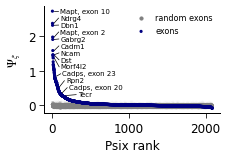

In [6]:
psix_results['bins'] = ['']*len(psix_results.index)

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure(figsize=(8*cm, 5*cm))
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons', s=10)

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02, s=10, edgecolors='none')
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='black', fontsize=7)   
ax.plot([20, 80], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black', linewidth=0.7)

plt.text(101, psix_results.loc['Mapt_1'].psix_score-0.25, 'Ndrg4', c='black', fontsize=7)   
ax.plot([20, 81], [psix_results.loc['Ndrg4_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.2],c='black', linewidth=0.7)

plt.text(102, psix_results.loc['Mapt_1'].psix_score-0.45, 'Dbn1', c='black', fontsize=7)   
ax.plot([20, 82], [psix_results.loc['Dbn1_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.4],c='black', linewidth=0.7)

plt.text(103, psix_results.loc['Mapt_1'].psix_score-0.65, 'Mapt, exon 2', c='black', fontsize=7)    
ax.plot([24, 83], [psix_results.loc['Mapt_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.6],c='black', linewidth=0.7)

plt.text(104, psix_results.loc['Mapt_1'].psix_score-0.85, 'Gabrg2', c='black', fontsize=7)   
ax.plot([25, 84], [psix_results.loc['Gabrg2_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.8],c='black', linewidth=0.7)

plt.text(105, psix_results.loc['Mapt_1'].psix_score-1.05, 'Cadm1', c='black', fontsize=7)    
ax.plot([24, 85], [psix_results.loc['Cadm1_10'].psix_score, psix_results.loc['Mapt_1'].psix_score-1],c='black', linewidth=0.7)

plt.text(106, psix_results.loc['Mapt_1'].psix_score-1.25, 'Ncam', c='black', fontsize=7)   
ax.plot([25, 86], [psix_results.loc['Ncam1_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.2],c='black', linewidth=0.7)

plt.text(107, psix_results.loc['Mapt_1'].psix_score-1.45, 'Dst', c='black', fontsize=7)    
ax.plot([24, 87], [psix_results.loc['Dst_5'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.4],c='black', linewidth=0.7)

plt.text(109, psix_results.loc['Mapt_1'].psix_score-1.65, 'Morf4l2', c='black', fontsize=7)   
ax.plot([25, 89], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.6],c='black', linewidth=0.7)

plt.text(129, psix_results.loc['Mapt_1'].psix_score-1.85, 'Cadps, exon 23', c='black', fontsize=7)   
ax.plot([55, 109], [psix_results.loc['Cadps_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.8],c='black', linewidth=0.7)


plt.text(177, psix_results.loc['Mapt_1'].psix_score-2.05, 'Rpn2', c='black', fontsize=7)   
ax.plot([65, 157], [psix_results.loc['Rpn2_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-2],c='black', linewidth=0.7)

plt.text(214, psix_results.loc['Mapt_1'].psix_score-2.25, 'Cadps, exon 20', c='black', fontsize=7)   
ax.plot([105, 194], [psix_results.loc['Cadps_2'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.2],c='black', linewidth=0.7)

plt.text(331, psix_results.loc['Mapt_1'].psix_score-2.45, 'Tecr', c='black', fontsize=7)   
ax.plot([125, 311], [psix_results.loc['Tecr_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.4],c='black', linewidth=0.7)

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons', s=10, zorder=200, edgecolors='none')
    
plt.xlabel('Psix rank', fontsize=12)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=12, length=5)
plt.legend(frameon=False, fontsize=8)

plt.savefig('plots/psix_scores.png', bbox_inches='tight', res=20000, dpi =2000)

# Identifying modules of splicing with Psix

Successfully computed neighbors


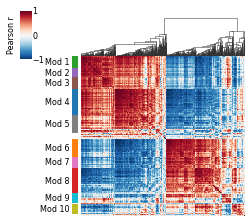

In [7]:
psix_object.compute_neighbors_psi(latent='data/preprocess/tables/pc3_rd.tab.gz', n_neighbors=100)
psix_object.compute_modules(min_gene_threshold=30)
modules = psix_object.plot_correlation_modules(plot_name = 'plots/exon_modules.png')

In [8]:
modules.Modules.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, -1])